In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
# from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from datasets import load_metric
from tqdm import tqdm


precision_score = load_metric("precision")
recall_score = load_metric("recall")
accuracy_score = load_metric("accuracy")
f1_score = load_metric("f1")        
roc_auc_score = load_metric("roc_auc", "multiclass") 

/tmp/ipykernel_46015/2189348149.py:14: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  precision_score = load_metric("precision")


### OHFT Triage

Here we will load in pickled data from the OHFT triage and run analysis comparing IID vs Concatenated vs Chunkkin models.

**NOTE** 
- Data folder to be used as of 04/12/23 is the data found at: /mnt/sdc/niallt/saved_models/pseudo_classification_tasks/ohft/all_ohft_results_cleaned_041223

In [2]:
# raw code 
# data_dir = "/mnt/sdc/niallt/saved_models/pseudo_classification_tasks/ohft/all_ohft_results_cleaned_041223/classification/results_plots/"
data_dir = "/mnt/sdc/niallt/saved_models/ohft_triage/iid_results/results_plots/"

# save path for figures
# save_path = "/mnt/sdc/niallt/saved_models/plm_triage_training/ohft/results/results_plots/paper_figures/"

save_path = "/mnt/sdc/niallt/saved_models/ohft_triage/figures/"


right now each models outputs are saved to separate files each, so would need to load them in separately

# Reload the files

## First the IID data

In [3]:
# function to load in the separate files

def load_iid_inference_results(data_dir, task_name, model_name):
    # first the results for the iid data
    iid_results = pickle.load(open(f"{data_dir}/{task_name}/{model_name}-instance_results.pickle", "rb"))
    # now the entropy df
    iid_entropy_df = pd.read_csv(f"{data_dir}/{task_name}/{model_name}-instance_entropies.csv")
    
    return iid_results, iid_entropy_df

In [4]:
# a compute metrics function

# for multiple metrics return a dictionary
def compute_metrics(predictions,  labels, pred_scores = None):
    
          

    precision = precision_score.compute(predictions=predictions, references=labels, average = "macro")["precision"]
    recall = recall_score.compute(predictions=predictions, references=labels, average = "macro")["recall"]
    accuracy = accuracy_score.compute(predictions=predictions, references=labels)["accuracy"]
    f1_macro = f1_score.compute(predictions=predictions, references=labels, average = "macro")["f1"]
    f1_weighted = f1_score.compute(predictions=predictions, references=labels, average = "weighted")["f1"]
    # roc_auc has slightly different format - needs the probs/scores rather than predicted labels
    if pred_scores is None:
        roc_auc = None
    else:
        roc_auc = roc_auc_score.compute(references=labels,
                                        prediction_scores = pred_scores,
                                        multi_class = 'ovr', 
                                        average = "macro")['roc_auc']
        
    
    
    return {"precision": precision, 
            "recall": recall,
            "accuracy": accuracy,
            "f1_macro":f1_macro,
            "f1_weighted":f1_weighted,
            "roc_auc_macro":roc_auc}


# the triage team subset class label mappings are fixed
triage_subset_class_label_mappings = {0:"EIP",
                        1:"ED",
                        2:"LD",
                        3:"oaCMHT",
                        4:"Perinatal"}

# set the class labels based on the mappings - hard code for now - it won't change anyway
class_labels = [v for k,v in triage_subset_class_label_mappings.items()]


    # create confusion matrix plot using seaborn
def plot_confusion_matrix(predictions,
                          labels,
                          class_labels,
                          task_name,
                          model_name,
                          normalize = None, 
                          save_path = None,
                          values_format = '.0f'):
    # create confusion matrix
    cm = confusion_matrix(labels, predictions, normalize="true")
    print(cm)
    fig,ax = plt.subplots(figsize=(10,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical', values_format = values_format)
    plt.title(f"{model_name} Confusion Matrix")
    if save_path is not None:
        plt.savefig(f"{save_path}/{task_name}_{model_name}_confusion_matrix.png", dpi = 300)
    
    plt.show()

In [79]:
class_labels

['EIP', 'ED', 'LD', 'oaCMHT', 'Perinatal']

In [5]:
# set the task name for the IID 
task_name = "accepted_triage_team_subset_removed_identifiers"

In [81]:
# check the files in the directory
!ls /mnt/sdc/niallt/saved_models/pseudo_classification_tasks/ohft/all_ohft_results_cleaned_0923/accepted_triage_team_subset_removed_identifiers/

roberta-base-cris-instance_doc_embeddings.pickle
roberta-base-cris-instance_entropies.csv
roberta-base-cris-instance_results.pickle
roberta-base-cris-note-custom_pretraining_1_weighted-instance_doc_embeddings.pickle
roberta-base-cris-note-custom_pretraining_1_weighted-instance_entropies.csv
roberta-base-cris-note-custom_pretraining_1_weighted-instance_results.pickle
roberta-base-cris-note-custom_pretraining_1_weighted-training_instance_doc_embeddings.pickle
roberta-base-cris-note-custom_pretraining_1_weighted-training_instance_entropies.csv
roberta-base-cris-note-custom_pretraining_1_weighted-training_instance_results.pickle
roberta-base-cris-training_instance_doc_embeddings.pickle
roberta-base-cris-training_instance_entropies.csv
roberta-base-cris-training_instance_results.pickle
roberta-base-declutr-instance_doc_embeddings.pickle
roberta-base-declutr-instance_entropies.csv
roberta-base-declutr-instance_results.pickle
roberta-base-declutr-training_instance_doc_embeddings.pickle
robert

In [6]:
# set a model name
model_name = "roberta-base-cris"

# load in the results
iid_results, iid_entropy_df = load_iid_inference_results(data_dir, task_name, model_name)

In [8]:
# check iid_results
# keys are pseudo ids
iid_results.keys()

dict_keys(['kFyGtwq8uw', 'YOXrECFrjX', 'NiAy28shBG', '5WTVD12ZHv', 'X9NBFIA4Bq', 'z5ZLFp8zSw', 'TnkHnW1HHd', 'tJkb3WBOiP', 'lyKaL2uBDu', '5MNMVBEHcK', 'e2cr6x7tSC', 'UFAOnUYTAP', 'RtdVcv2Fua', '7Wt0sDes2I', 'BbvW1G1cnQ', 'uWKZCf3oAi', 'jv6ueFzTsZ', 'R6a9jMciEv', 'i1ZVKmTwuZ', 'vz7IeK9Xrd', 'fgrt14blGI', 'MMYwV3HsPO', 'EpEZYa6euS', 'OjsPALyLnR', 'ALNKZDA2Sg', 'r1CqTXulC8', '1Xbfe4xPEA', 'gV6zuEDUdR', '0aeFYRYkUf', 'kphJ51uOpU', 'lL3sImc2zm', 'nnBBS6erQz', 'dZdzH9Q9iC', '5wO1MBxZ7H', 'wsQFLsxQkD', 'dk8HCYgs0L', 'YYnXlytxNx', 'XvK9FocJ0s', 'pmNgUZSI4C', 'zJHEUnOZhh', 'jzK0GdXGbQ', 'MylXrXkpiy', 'g5pzuBlRWK', 'TDsLH0DIQM', 'sOzfRYkhNp', 'VyZGDeq8o8', 'furQUpDUuq', 'IHTIA9folD', 'xNV6NAg9dr', 'BCPPRfnHkW', '5M6iMLtE3G', 'AclfbSY3zu', '5XiMc9DVui', 'OiBIM0MRbr', 'CmHinoH7aG', 'RjIQVerile', 'qdikQB89gF', 'VZa53cnn6H', 'rRAHM7CAc0', 't9kdL8k1rE', 'YlwSbouFpM', 'ou9bmWJONG', 'e2ZdS73OWF', 'xMMI45TjnG', 'z7k7gPqvXt', '2cIBBsuEgA', 'WdSpqTd8NM', 'izi5E9zQhE', 'pUWyVkbmfi', 'Wa6SwrL8Ch', 'H7V29nWw

the entropy dfs are most important for now

In [84]:
iid_entropy_df.head()

,brc_id,num_instance,doc_id,entropy,probs,labels,preds,num_tokens
0,kFyGtwq8uw,2,0,0.152917,"[0.969575047492981, 0.002089192857965827, 0.00...",2,0,490
1,kFyGtwq8uw,2,1,0.662433,"[0.16557419300079346, 0.0034319288097321987, 0...",2,3,120
2,kFyGtwq8uw,2,2,0.011214,"[0.9987356066703796, 0.0002743233635555953, 0....",2,0,187
3,kFyGtwq8uw,2,3,0.047702,"[0.006901256740093231, 0.0002466753649059683, ...",2,4,58
4,kFyGtwq8uw,2,4,0.004277,"[0.9995775818824768, 0.00015047364286147058, 8...",2,0,56


### IID Analysis plan - Ensemble voting
1.) simply use a mode voting scheme to get the predictions for each model

In [7]:
# make a copy of the entropy df
instance_entropy_dfs = iid_entropy_df.copy()

In [8]:
# this is a per document set of classifications
instance_entropy_dfs.shape

(157880, 8)

In [9]:
# double chekc number of unique brc_ids
instance_entropy_dfs.brc_id.nunique()

2853

In [10]:
# groupby brc_id and number of instance to get the mode predictions
mode_instance_entropy_preds = instance_entropy_dfs.groupby(["brc_id", "num_instance"])["preds"].agg(lambda x: x.mode()[0]).reset_index()
# the preds has been replaced by the mode - lets rename
mode_instance_entropy_preds.rename(columns={"preds": "mode_preds"}, inplace=True)

In [11]:
# now we have a mode prediciton for each instance, rather than each document
mode_instance_entropy_preds

,brc_id,num_instance,mode_preds
0,00czoiL4yp,2,3
1,04TZiUOc9u,2,3
2,04kZ0Mnqbp,2,3
3,04kZ0Mnqbp,3,3
4,05BHBZzVzo,2,3
...,...,...,...
4267,zxMdL2SUYD,8,3
4268,zxUPNQImbx,2,3
4269,zxUPNQImbx,3,3
4270,zxfJOTEPCA,2,3


In [12]:
# now we want to merge back to the original entropy df 
# this will give us the mode prediction for each instance
mode_instance_entropy_dfs = pd.merge( mode_instance_entropy_preds, instance_entropy_dfs[["brc_id", "num_instance","labels"]],
                                     on = ["brc_id", "num_instance"], how = "inner").drop_duplicates()

In [91]:
# now we get the mode predictions for each instance as well as the original label
mode_instance_entropy_dfs

,brc_id,num_instance,mode_preds,labels
0,00czoiL4yp,2,3,3
10,04TZiUOc9u,2,3,3
11,04kZ0Mnqbp,2,3,3
13,04kZ0Mnqbp,3,3,3
22,05BHBZzVzo,2,3,3
...,...,...,...,...
157833,zxMdL2SUYD,8,3,3
157839,zxUPNQImbx,2,3,3
157843,zxUPNQImbx,3,3,3
157870,zxfJOTEPCA,2,3,3


In [13]:
# check results
iid_metrics = compute_metrics(mode_instance_entropy_dfs.mode_preds, mode_instance_entropy_dfs.labels)
# add model_name
iid_metrics["model_name"] = model_name

In [14]:
iid_metrics

{'precision': 0.8284391592577908,
 'recall': 0.8820937672618934,
 'accuracy': 0.9477996254681648,
 'f1_macro': 0.8456978588361668,
 'f1_weighted': 0.9496755534507069,
 'roc_auc_macro': None,
 'model_name': 'roberta-base-cris'}

#### function to loop over mutliple models and get the predictions


In [13]:
def get_multi_iid_results(data_dir, task_name, model_names):
    
    # crude - but some model name mappings
    long_model_name_mappings = {
        "roberta-base": "RoBERTa-base",
        "roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted": "RoBERTa-mimic-note",
        "mimic-roberta-base": "RoBERTa-mimic",
        "roberta-base-2_anch_2_pos_min_1024": "RoBERTa-mimic-DeCLUTR",
        "roberta-base-cris": "RoBERTa-cris",
        "roberta-base-declutr-2_anch_2_pos_min_64":"RoBERTA-cris-DeCLUTR",
        "roberta-base-cris-note-custom_pretraining_1":"RoBERTa-cris-note",
        "roberta-base_declutr":"RoBERTa-mimic-DeCLUTR",   
        "mimic-simcse" : "mimic-simcse", 
        "mimic-roberta-base_declutr":"minic-roberta-base-DeCLUTR",
        "declutr-base": "DeCLUTR-base",                
        "all-mpnet-base-v2": "all-mpnet-base-v2", 
        "roberta-base-cris": "RoBERTa-OHFT",
        "roberta-base-declutr": "RoBERTa-OHFT-DeCLUTR",
        "roberta-base-cris-note-custom_pretraining_1_weighted": "RoBERTa-OHFT-Note",
                               
        }
    # create empty list to store results
    results = []
    # loop through model names
    for model_name in tqdm(model_names):
        # load in the results
        iid_results, iid_entropy_df = load_iid_inference_results(data_dir, task_name, model_name)
        
        # make a copy of the entropy df
        instance_entropy_dfs = iid_entropy_df.copy()
        # groupby brc_id and number of instance to get the mode predictions
        mode_instance_entropy_preds = instance_entropy_dfs.groupby(["brc_id", "num_instance"])["preds"].agg(lambda x: x.mode()[0]).reset_index()
        # the preds has been replaced by the mode - lets rename
        mode_instance_entropy_preds.rename(columns={"preds": "mode_preds"}, inplace=True)
        
        # now we want to merge back to the original entropy df 
        # this will give us the mode prediction for each instance
        mode_instance_entropy_dfs = pd.merge( mode_instance_entropy_preds, instance_entropy_dfs[["brc_id", "num_instance","labels"]],
                                            on = ["brc_id", "num_instance"], how = "inner").drop_duplicates()
        
        # check results
        iid_metrics = compute_metrics(mode_instance_entropy_dfs.mode_preds, mode_instance_entropy_dfs.labels)
        # add model_name based on long name mappings
        iid_metrics["model_name"] = long_model_name_mappings[model_name]
        
        # add to results
        results.append(iid_metrics)
        
    # convert to df
    results_df = pd.DataFrame(results)
    
    return results_df

In [14]:
model_names = ["roberta-base","roberta-base-cris", "roberta-base-declutr", "roberta-base-cris-note-custom_pretraining_1_weighted"]

# get multi results
iid_results_df = get_multi_iid_results(data_dir, task_name, model_names)

100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


In [96]:
iid_results_df

,precision,recall,accuracy,f1_macro,f1_weighted,roc_auc_macro,model_name
0,0.780452,0.859222,0.923221,0.801109,0.928550,None,RoBERTa-base
1,0.828439,0.882094,0.947800,0.845698,0.949676,None,RoBERTa-OHFT
2,0.790413,0.864603,0.929775,0.811904,0.933911,None,RoBERTa-OHFT-DeCLUTR
3,0.796221,0.859968,0.932584,0.814505,0.936345,None,RoBERTa-OHFT-Note


In [97]:
iid_results_df

,precision,recall,accuracy,f1_macro,f1_weighted,roc_auc_macro,model_name
0,0.780452,0.859222,0.923221,0.801109,0.928550,None,RoBERTa-base
1,0.828439,0.882094,0.947800,0.845698,0.949676,None,RoBERTa-OHFT
2,0.790413,0.864603,0.929775,0.811904,0.933911,None,RoBERTa-OHFT-DeCLUTR
3,0.796221,0.859968,0.932584,0.814505,0.936345,None,RoBERTa-OHFT-Note


### IID Analysis plan - Ensemble voting based on entropy? 

We could only accept votes from models that have a certain entropy threshold, and then use a mode voting scheme to get the predictions for each model


**Special cases**

- This would require handling of the case where an instance has no documents with a low entropy

# Concatenated sequence

In [15]:
# function to load in the separate files

def load_concat_inference_results(data_dir, task_name, model_name):
    # first the results for the iid data
    concat_results = pickle.load(open(f"{data_dir}/{task_name}/{model_name}-concat_instance_results.pickle", "rb"))
    # now the entropy df
    concat_df = pd.read_csv(f"{data_dir}/{task_name}/{model_name}-concat_instance_results_df.csv")
    
    return concat_results, concat_df

### Concatenated Analysis plan 
1.) Straight forward classification

#### 1st look at the simplest, and crudest - most recent 512 tokens
vanilla transformers with full attention can only handle 512 tokens - but we train using the most recent 512 tokens of a patients history. 

In [16]:
concat_model_name = "roberta-base-cris" # or Clinical-Longformer
#NOTE - longformer has much longer max tokens
concat_task_name = "accepted_triage_team_subset_concat_removed_identifiers"
concat_data_dir = "/mnt/sdc/niallt/saved_models/ohft_triage/concat_results/results_plots/"

In [17]:
# load the data
concat_results, concat_results_df = load_concat_inference_results(concat_data_dir, concat_task_name, concat_model_name)

In [20]:
concat_results_df.head()

,brc_id,num_instance,probs,entropy,labels,preds,num_tokens
0,kFyGtwq8uw,2,"[0.00018576689762994647, 0.9990265369415283, 0...",0.008977,2,1,512
1,YOXrECFrjX,2,"[4.900489784631645e-06, 7.631965672771912e-06,...",0.000301,3,3,99
2,NiAy28shBG,2,"[5.373967724153772e-06, 1.0438404387969058e-05...",0.000325,3,3,512
3,5WTVD12ZHv,5,"[0.11929530650377274, 0.11580677330493927, 0.0...",1.263298,4,3,512
4,X9NBFIA4Bq,3,"[6.36444792689872e-06, 1.0661626220098697e-05,...",0.000336,3,3,512


In [21]:
concat_results_df.head()

,brc_id,num_instance,probs,entropy,labels,preds,num_tokens
0,kFyGtwq8uw,2,"[0.00018576689762994647, 0.9990265369415283, 0...",0.008977,2,1,512
1,YOXrECFrjX,2,"[4.900489784631645e-06, 7.631965672771912e-06,...",0.000301,3,3,99
2,NiAy28shBG,2,"[5.373967724153772e-06, 1.0438404387969058e-05...",0.000325,3,3,512
3,5WTVD12ZHv,5,"[0.11929530650377274, 0.11580677330493927, 0.0...",1.263298,4,3,512
4,X9NBFIA4Bq,3,"[6.36444792689872e-06, 1.0661626220098697e-05,...",0.000336,3,3,512


In [18]:
# get metrics 
concat_metrics = compute_metrics(concat_results_df.preds, concat_results_df.labels)
# add model type to metrics
concat_metrics["model_name"] = f"{concat_model_name}-concat"

In [23]:
concat_metrics

{'precision': 0.927445350519364,
 'recall': 0.9174408648351848,
 'accuracy': 0.9735486891385767,
 'f1_macro': 0.922159843395485,
 'f1_weighted': 0.9734543441513962,
 'roc_auc_macro': None,
 'model_name': 'roberta-base-cris-concat'}

In [105]:
concat_metrics

{'precision': 0.927445350519364,
 'recall': 0.9174408648351848,
 'accuracy': 0.9735486891385767,
 'f1_macro': 0.922159843395485,
 'f1_weighted': 0.9734543441513962,
 'roc_auc_macro': None,
 'model_name': 'roberta-base-cris-concat'}

#### Using longformer - 4096 tokens

In [19]:
long_model_name = "Clinical-Longformer"
# get results and metrics
long_concat_results, long_concat_results_df = load_concat_inference_results(concat_data_dir, concat_task_name, long_model_name)
long_concat_metrics = compute_metrics(long_concat_results_df.preds, long_concat_results_df.labels)

# add the model type
long_concat_metrics["model_name"] = long_model_name

In [20]:
# long metrics
long_concat_metrics

{'precision': 0.9323571757170633,
 'recall': 0.9180312628914453,
 'accuracy': 0.9749531835205992,
 'f1_macro': 0.9239493120439148,
 'f1_weighted': 0.9748987341453339,
 'roc_auc_macro': None,
 'model_name': 'Clinical-Longformer'}

In [108]:
# short concat metrics
concat_metrics

{'precision': 0.927445350519364,
 'recall': 0.9174408648351848,
 'accuracy': 0.9735486891385767,
 'f1_macro': 0.922159843395485,
 'f1_weighted': 0.9734543441513962,
 'roc_auc_macro': None,
 'model_name': 'roberta-base-cris-concat'}

In [109]:
# remind self of iid results
iid_metrics

{'precision': 0.8284391592577908,
 'recall': 0.8820937672618934,
 'accuracy': 0.9477996254681648,
 'f1_macro': 0.8456978588361668,
 'f1_weighted': 0.9496755534507069,
 'roc_auc_macro': None,
 'model_name': 'roberta-base-cris'}

In [21]:
# merge all three metrics into a df
all_concat_metrics = pd.DataFrame([ concat_metrics, long_concat_metrics])
all_metrics = pd.concat([iid_results_df, all_concat_metrics])

In [22]:
all_metrics

,precision,recall,accuracy,f1_macro,f1_weighted,roc_auc_macro,model_name
0,0.780452,0.859222,0.923221,0.801109,0.928550,None,RoBERTa-base
1,0.828439,0.882094,0.947800,0.845698,0.949676,None,RoBERTa-OHFT
2,0.790413,0.864603,0.929775,0.811904,0.933911,None,RoBERTa-OHFT-DeCLUTR
3,0.796221,0.859968,0.932584,0.814505,0.936345,None,RoBERTa-OHFT-Note
0,0.927445,0.917441,0.973549,0.922160,0.973454,None,roberta-base-cris-concat
1,0.932357,0.918031,0.974953,0.923949,0.974899,None,Clinical-Longformer


In [23]:
# move model name to the front
cols = all_metrics.columns.tolist()
cols = cols[-1:] + cols[:-1]
all_metrics = all_metrics[cols]


In [113]:
# print latex table
print(all_metrics.to_latex(index=False))

\begin{tabular}{lrrrrrl}
\toprule
              model\_name &  precision &   recall &  accuracy &  f1\_macro &  f1\_weighted & roc\_auc\_macro \\
\midrule
            RoBERTa-base &   0.780452 & 0.859222 &  0.923221 &  0.801109 &     0.928550 &          None \\
            RoBERTa-OHFT &   0.828439 & 0.882094 &  0.947800 &  0.845698 &     0.949676 &          None \\
    RoBERTa-OHFT-DeCLUTR &   0.790413 & 0.864603 &  0.929775 &  0.811904 &     0.933911 &          None \\
       RoBERTa-OHFT-Note &   0.796221 & 0.859968 &  0.932584 &  0.814505 &     0.936345 &          None \\
roberta-base-cris-concat &   0.927445 & 0.917441 &  0.973549 &  0.922160 &     0.973454 &          None \\
     Clinical-Longformer &   0.932357 & 0.918031 &  0.974953 &  0.923949 &     0.974899 &          None \\
\bottomrule
\end{tabular}



/tmp/ipykernel_41635/1050610575.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(all_metrics.to_latex(index=False))


In [27]:
# function to produce latex table
def produce_latex_table(df, caption, label, index = False, multirow = True, multicolumn = True, float_format = "%.3f", position = "htp", do_printing = True):
    

    
    # rename columns
    df = df.rename(columns={
                       "model_name":"Model",
                                                "accuracy":"Accuracy",
                                                "f1_macro":"F1",
                                                # "roc_auc":"AUC",
                                                "precision":"Precision",
                                                "recall":"Recall",
                                                })
    
    # actually now we have renamed models
    
    # subset and reorder columns   
    df = df[["Model", "Accuracy","F1", "Precision", "Recall"]]
    
    if do_printing:
        # print latex
        print(df.to_latex(index = index,
                                                        multirow= multirow,
                                                        multicolumn=multicolumn,
                                                        float_format=float_format,
                                                        position = position,
                                                        caption = caption,
                                                        label = label,))
    else:
        return df.to_latex(index = index,
                                                        multirow= multirow,
                                                        multicolumn=multicolumn,
                                                        float_format=float_format,
                                                        position = position,
                                                        caption = caption,
                                                        label = label)

In [115]:
# produce latex
produce_latex_table(all_metrics, caption = "Classification metrics for IID voting versus concatenated sequences...", label = "tab:classification_metrics")

\begin{table}[htp]
\centering
\caption{Classification metrics for IID voting versus concatenated sequences...}
\label{tab:classification_metrics}
\begin{tabular}{lrrrr}
\toprule
                   Model &  Accuracy &    F1 &  Precision &  Recall \\
\midrule
            RoBERTa-base &     0.923 & 0.801 &      0.780 &   0.859 \\
            RoBERTa-OHFT &     0.948 & 0.846 &      0.828 &   0.882 \\
    RoBERTa-OHFT-DeCLUTR &     0.930 & 0.812 &      0.790 &   0.865 \\
       RoBERTa-OHFT-Note &     0.933 & 0.815 &      0.796 &   0.860 \\
roberta-base-cris-concat &     0.974 & 0.922 &      0.927 &   0.917 \\
     Clinical-Longformer &     0.975 & 0.924 &      0.932 &   0.918 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_41635/1815676337.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index = index,


In [116]:
# double check the distribution of labels in test set
concat_results_df.labels.value_counts()

3    3421
0     271
1     244
2     177
4     159
Name: labels, dtype: int64

In [117]:
mode_instance_entropy_dfs.labels.value_counts()

3    3421
0     271
1     244
2     177
4     159
Name: labels, dtype: int64

In [118]:
mode_instance_entropy_dfs.mode_preds.value_counts()

3    3340
0     317
4     233
2     194
1     188
Name: mode_preds, dtype: int64

In [119]:
class_labels

['EIP', 'ED', 'LD', 'oaCMHT', 'Perinatal']

[[9.11439114e-01 2.21402214e-02 1.10701107e-02 4.79704797e-02
  7.38007380e-03]
 [1.63934426e-02 9.13934426e-01 4.09836066e-03 3.27868852e-02
  3.27868852e-02]
 [1.69491525e-02 1.69491525e-02 9.15254237e-01 5.08474576e-02
  0.00000000e+00]
 [4.38468284e-03 1.46156095e-03 2.63080970e-03 9.91230634e-01
  2.92312189e-04]
 [2.51572327e-02 6.28930818e-02 1.25786164e-02 4.40251572e-02
  8.55345912e-01]]


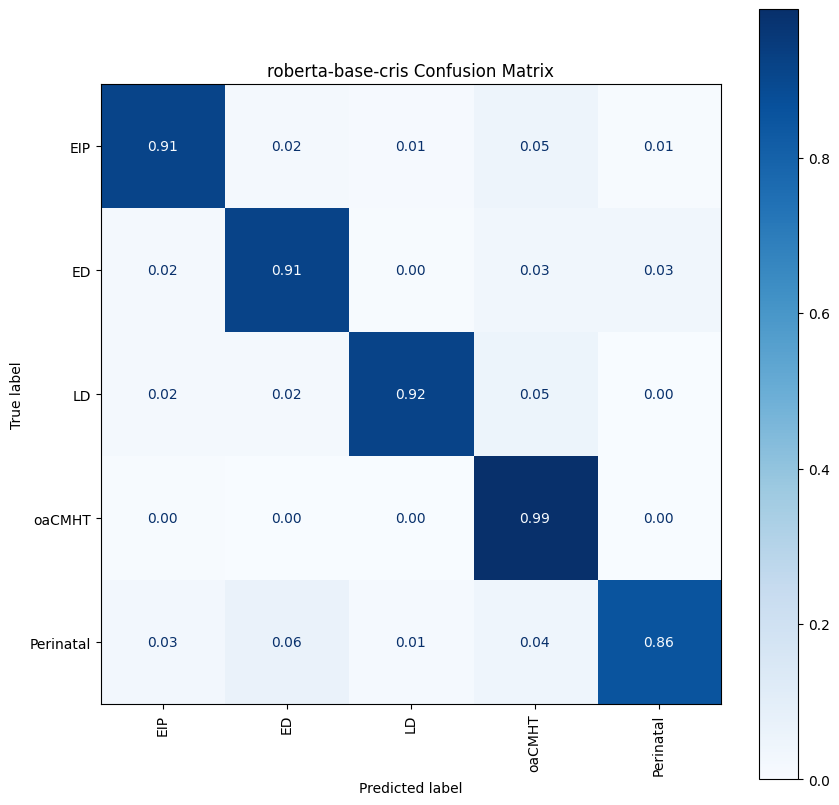

In [120]:
# plot confusion matrix for concat model
plot_confusion_matrix(concat_results_df.preds,
                      concat_results_df.labels,
                      class_labels,
                      concat_task_name,
                      concat_model_name,
                      normalize=False, # | "true"
                      save_path = "./",
                      values_format = '.2f')

[[0.91881919 0.02214022 0.01107011 0.03690037 0.01107011]
 [0.02459016 0.93442623 0.00409836 0.0204918  0.01639344]
 [0.01129944 0.03954802 0.92090395 0.02824859 0.        ]
 [0.00204619 0.00409237 0.00175387 0.99210757 0.        ]
 [0.03773585 0.06918239 0.         0.06918239 0.82389937]]


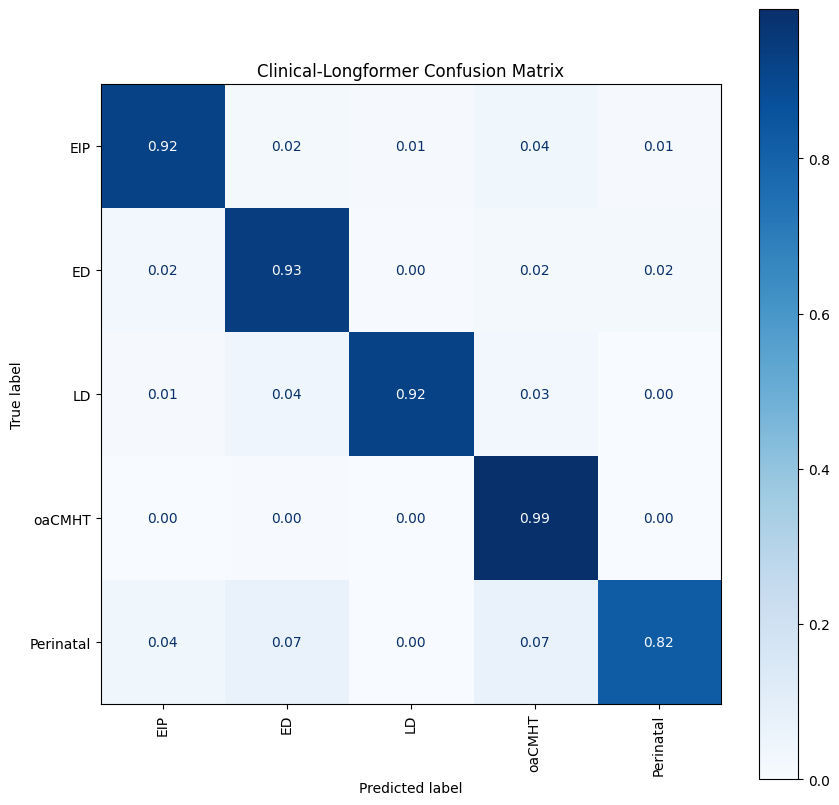

In [121]:
# same for the longformer
plot_confusion_matrix(long_concat_results_df.preds,
                      long_concat_results_df.labels,
                      class_labels,
                      concat_task_name,
                      long_model_name,
                      normalize=False, # | "true"
                      save_path = "./",
                      values_format = '.2f')

## Load batch and segment chunking results

In [24]:
task = "accepted_triage_team_subset_concat_removed_identifiers"
task_save_name = "accepted_triage_team_subset_concat"# dumb but due to accidental renaming of same task
# chunk_data_dir = "/mnt/sdc/niallt/saved_models/pseudo_classification_tasks/ohft/all_ohft_results_cleaned_041223/plm_triage/results_plots/"
chunk_data_dir = "/mnt/sdc/niallt/saved_models/ohft_triage/segment_batch_results/results_plots/"

In [25]:
chunk_model_name = "roberta-base-cris_all_data-256"

In [26]:
chunk_results_df = pd.read_csv(f"{chunk_data_dir}/{task}/{chunk_model_name}_eval_results_df.csv")

In [27]:
chunk_metrics_df = pd.DataFrame([compute_metrics(chunk_results_df.preds, chunk_results_df.labels)])
chunk_metrics_df["model_name"] = chunk_model_name

In [28]:
# combine with other metrics
all_metrics = pd.concat([all_metrics, chunk_metrics_df])

In [33]:
all_metrics

,model_name,precision,recall,accuracy,f1_macro,f1_weighted,roc_auc_macro
0,RoBERTa-base,0.780452,0.859222,0.923221,0.801109,0.928550,None
1,RoBERTa-OHFT,0.828439,0.882094,0.947800,0.845698,0.949676,None
2,RoBERTa-OHFT-DeCLUTR,0.790413,0.864603,0.929775,0.811904,0.933911,None
3,RoBERTa-OHFT-Note,0.796221,0.859968,0.932584,0.814505,0.936345,None
0,roberta-base-cris-concat,0.927445,0.917441,0.973549,0.922160,0.973454,None
1,Clinical-Longformer,0.932357,0.918031,0.974953,0.923949,0.974899,None
0,roberta-base-cris_all_data-256,0.942429,0.933323,0.980571,0.937800,0.980520,None


In [29]:
# rename columns
all_metrics = all_metrics.rename(columns={
                       "model_name":"Model",
                                                "accuracy":"Accuracy",
                                                "f1_macro":"F1",
                                                # "roc_auc":"AUC",
                                                "precision":"Precision",
                                                "recall":"Recall",
                                                })

# actually now we have renamed models

# subset and reorder columns
all_metrics = all_metrics[["Model", "Accuracy","F1", "Precision", "Recall"]]



In [30]:
# print latex
print(all_metrics.to_latex(index = False,
                                                        multirow= True,
                                                        multicolumn=True,
                                                        float_format="%.3f",
                                                        position = "htp",
                                                        caption = "Classification metrics for IID voting versus concatenated sequences...",
                                                        label = "tab:classification_metrics",)
                                )

\begin{table}[htp]
\centering
\caption{Classification metrics for IID voting versus concatenated sequences...}
\label{tab:classification_metrics}
\begin{tabular}{lrrrr}
\toprule
                         Model &  Accuracy &    F1 &  Precision &  Recall \\
\midrule
                  RoBERTa-base &     0.923 & 0.801 &      0.780 &   0.859 \\
                  RoBERTa-OHFT &     0.948 & 0.846 &      0.828 &   0.882 \\
          RoBERTa-OHFT-DeCLUTR &     0.930 & 0.812 &      0.790 &   0.865 \\
             RoBERTa-OHFT-Note &     0.933 & 0.815 &      0.796 &   0.860 \\
      roberta-base-cris-concat &     0.974 & 0.922 &      0.927 &   0.917 \\
           Clinical-Longformer &     0.975 & 0.924 &      0.932 &   0.918 \\
roberta-base-cris\_all\_data-256 &     0.981 & 0.938 &      0.942 &   0.933 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_46015/21902529.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(all_metrics.to_latex(index = False,


# Look at performance dependent on lengths
Here we can explore how each model appears to handle short | medium | long sequences

Here we actually use the tokenized lengths from raw data to ensure we can isolate the notes lower or above 4096.

More on this on the AWS server at: "/mnt/sdc/niallt/saved_models/pseudo_classification_tasks/ohft/all_ohft_results_cleaned_041223/Code/CRIS_Projects/pseudo_classification_tasks/plotting/load_ohft_results_plot.ipynb"

In [31]:
short_cutoff = 128
medium_cutoff = 512
long_cutoff = 4096

In [32]:
# now we want to load in the raw concat data dist to ensure we get right token nums
triage_data_dir = "/mnt/sdc/niallt/saved_models/pseudo_classification_tasks/ohft/all_ohft_results_cleaned_041223/classification/results_plots/dataset_dist_no_ids/"
train_iid_df = pd.read_csv(f"{triage_data_dir}/train_iid_df.csv")
eval_iid_df = pd.read_csv(f"{triage_data_dir}/eval_iid_df.csv")

# same for concat
train_concat_df = pd.read_csv(f"{triage_data_dir}/train_concat_df.csv")
eval_concat_df = pd.read_csv(f"{triage_data_dir}/eval_concat_df.csv")

# rename id brc id
eval_concat_df.rename(columns={"id":"brc_id"}, inplace=True)

In [132]:
eval_concat_df 

,brc_id,accepted_triage_team,label,num_instance,num_tokens
0,bv62ZhRWYX,OlderAdultCMHT,3,2,1279
1,1reX3f7H5p,OlderAdultCMHT,3,3,1662
2,if3wKdDqnm,OlderAdultCMHT,3,3,271
3,Dq64tC9ypo,OlderAdultCMHT,3,2,252
4,lKI6eebyaN,OlderAdultCMHT,3,2,95423
...,...,...,...,...,...
4267,2FMqDcF1ES,OlderAdultCMHT,3,2,129
4268,ISR8SIbM8K,OlderAdultCMHT,3,2,103
4269,i7hv4nzZ8S,OlderAdultCMHT,3,3,418
4270,ZL9H7WYoWn,OlderAdultCMHT,3,2,798


In [133]:
# now we want to use the concat df to get the token nums for each dataframe

iid_entropy_df.brc_id.nunique()

2853

In [134]:
eval_concat_df.brc_id.nunique() 

2853

In [33]:
eval_concat_df.rename(columns = {"num_tokens":"raw_num_tokens"}, inplace=True)


In [34]:
# need to map num tokens based on brc_id and num_instance
long_concat_results_df = long_concat_results_df.merge(eval_concat_df[["brc_id", "num_instance", "raw_num_tokens"]], on = ["brc_id", "num_instance"], how = "inner")
# same for concat and chunk
concat_results_df = concat_results_df.merge(eval_concat_df[["brc_id", "num_instance", "raw_num_tokens"]], on = ["brc_id", "num_instance"], how = "inner")
chunk_results_df = chunk_results_df.merge(eval_concat_df[["brc_id", "num_instance", "raw_num_tokens"]], on = ["brc_id", "num_instance"], how = "inner")
# and same for iid df
mode_instance_entropy_dfs = mode_instance_entropy_dfs.merge(eval_concat_df[["brc_id", "num_instance", "raw_num_tokens"]], on = ["brc_id", "num_instance"], how = "inner")

In [137]:
mode_instance_entropy_dfs

,brc_id,num_instance,mode_preds,labels,raw_num_tokens
0,00czoiL4yp,2,3,3,3119
1,04TZiUOc9u,2,3,3,41
2,04kZ0Mnqbp,2,3,3,343
3,04kZ0Mnqbp,3,3,3,2388
4,05BHBZzVzo,2,3,3,41
...,...,...,...,...,...
4267,zxMdL2SUYD,8,3,3,1635
4268,zxUPNQImbx,2,3,3,1963
4269,zxUPNQImbx,3,3,3,5737
4270,zxfJOTEPCA,2,3,3,23


In [138]:
long_concat_results_df.sort_values(["brc_id", "num_instance"])

,brc_id,num_instance,probs,entropy,labels,preds,num_tokens,raw_num_tokens
2544,00czoiL4yp,2,"[6.083778862375766e-05, 8.176788105629385e-05,...",0.003215,3,3,3119,3119
4178,04TZiUOc9u,2,"[6.783874414395541e-05, 0.00010029511759057641...",0.003523,3,3,41,41
953,04kZ0Mnqbp,2,"[6.658599158981815e-05, 8.733244612812996e-05,...",0.003360,3,3,343,343
954,04kZ0Mnqbp,3,"[5.992734440951608e-05, 8.578492270316929e-05,...",0.003205,3,3,2388,2388
3954,05BHBZzVzo,2,"[7.003775681369007e-05, 0.00010409999958937988...",0.003532,3,3,41,41
...,...,...,...,...,...,...,...,...
1162,zxMdL2SUYD,8,"[7.002098573138937e-05, 0.00010890966950682923...",0.003624,3,3,1635,1635
551,zxUPNQImbx,2,"[0.00033287808764725924, 0.0009480906301178038...",0.015732,3,3,1963,1963
552,zxUPNQImbx,3,"[8.894023631000891e-05, 0.00013892182323615998...",0.004112,3,3,4096,5737
2535,zxfJOTEPCA,2,"[6.584368384210393e-05, 9.697824862087145e-05,...",0.003566,3,3,23,23


In [139]:
chunk_results_df.sort_values(["brc_id", "num_instance"])

,brc_id,num_instance,probs,labels,preds,raw_num_tokens
3492,00czoiL4yp,2,[1.0828648e-05 1.3041305e-05 3.9150280e-05 9.9...,3,3,3119
1252,04TZiUOc9u,2,[1.7471244e-05 1.9037228e-05 5.1553885e-05 9.9...,3,3,41
787,04kZ0Mnqbp,2,[7.2969483e-06 9.0391459e-06 2.2795732e-05 9.9...,3,3,343
3585,04kZ0Mnqbp,3,[1.0131798e-05 1.1257204e-05 2.7729018e-05 9.9...,3,3,2388
430,05BHBZzVzo,2,[1.3305527e-05 1.7173796e-05 4.7332887e-05 9.9...,3,3,41
...,...,...,...,...,...,...
1524,zxMdL2SUYD,8,[9.1790471e-06 1.8458257e-05 5.9798963e-06 9.9...,3,3,1635
40,zxUPNQImbx,2,[7.5427815e-05 2.7633269e-04 3.1855376e-05 9.9...,3,3,1963
1137,zxUPNQImbx,3,[9.3365334e-06 2.3159637e-05 7.6553952e-06 9.9...,3,3,5737
2534,zxfJOTEPCA,2,[9.8603086e-06 1.4367735e-05 3.9332379e-05 9.9...,3,3,23


now we can look at metrics based on the cut offs for each model type

In [35]:
# short 
short_concat_results = concat_results_df.query("raw_num_tokens < @short_cutoff")
short_long_concat_results = long_concat_results_df.query("raw_num_tokens < @short_cutoff")
short_iid_results = mode_instance_entropy_dfs.query("raw_num_tokens < @short_cutoff")
short_chunk_results = chunk_results_df.query("raw_num_tokens < @short_cutoff")
# medium
medium_concat_results = concat_results_df.query("raw_num_tokens < @medium_cutoff & raw_num_tokens > @short_cutoff")
medium_long_concat_results = long_concat_results_df.query("raw_num_tokens < @medium_cutoff & raw_num_tokens > @short_cutoff")
medium_iid_results = mode_instance_entropy_dfs.query("raw_num_tokens < @medium_cutoff & raw_num_tokens > @short_cutoff")
medium_chunk_results = chunk_results_df.query("raw_num_tokens < @medium_cutoff & raw_num_tokens > @short_cutoff")
# long
long_concat_results = concat_results_df.query("raw_num_tokens < @long_cutoff & raw_num_tokens > @medium_cutoff")
long_long_concat_results = long_concat_results_df.query("raw_num_tokens < @long_cutoff & raw_num_tokens > @medium_cutoff")
long_iid_results = mode_instance_entropy_dfs.query("raw_num_tokens < @long_cutoff & raw_num_tokens > @medium_cutoff")
long_chunk_results = chunk_results_df.query("raw_num_tokens < @long_cutoff & raw_num_tokens > @medium_cutoff")
# extra long
extra_long_concat_results = concat_results_df.query("raw_num_tokens > @long_cutoff")
extra_long_long_concat_results = long_concat_results_df.query("raw_num_tokens > @long_cutoff")
extra_long_iid_results = mode_instance_entropy_dfs.query("raw_num_tokens > @long_cutoff")
extra_long_chunk_results = chunk_results_df.query("raw_num_tokens > @long_cutoff")


# get short metrics
short_concat_metrics = compute_metrics(short_concat_results.preds, short_concat_results.labels)
short_long_concat_metrics = compute_metrics(short_long_concat_results.preds, short_long_concat_results.labels)
short_iid_metrics = compute_metrics(short_iid_results.mode_preds, short_iid_results.labels)
short_chunk_metrics = compute_metrics(short_chunk_results.preds, short_chunk_results.labels)

# set model names to each
short_concat_metrics["model_name"] = f"{concat_model_name}-concat"  
short_long_concat_metrics["model_name"] = long_model_name
short_iid_metrics["model_name"] = model_name
short_chunk_metrics["model_name"] = chunk_model_name

# add the method used by each modelling approach too
short_iid_metrics["method"] = "brute"
short_concat_metrics["method"] = "concat"
short_long_concat_metrics["method"] = "longformer"
short_chunk_metrics["method"] = "chunk"

# send to df
short_metrics_df = pd.DataFrame([short_iid_metrics, short_concat_metrics, short_long_concat_metrics,  short_chunk_metrics])

# add instance_length as a column based on cutoff
short_metrics_df["instance_length"] = "short"

# add number of samples
short_metrics_df["num_samples"] = short_concat_results.shape[0]

# medium
medium_concat_metrics = compute_metrics(medium_concat_results.preds, medium_concat_results.labels)
medium_long_concat_metrics = compute_metrics(medium_long_concat_results.preds, medium_long_concat_results.labels)
medium_iid_metrics = compute_metrics(medium_iid_results.mode_preds, medium_iid_results.labels)
medium_chunk_metrics = compute_metrics(medium_chunk_results.preds, medium_chunk_results.labels)

# set model names to each
medium_concat_metrics["model_name"] = f"{concat_model_name}-concat"
medium_long_concat_metrics["model_name"] = long_model_name
medium_iid_metrics["model_name"] = model_name
medium_chunk_metrics["model_name"] = chunk_model_name

# add the method used by each modelling approach too
medium_iid_metrics["method"] = "brute"
medium_concat_metrics["method"] = "concat"
medium_long_concat_metrics["method"] = "longformer"
medium_chunk_metrics["method"] = "chunk"

# send to df
medium_metrics_df = pd.DataFrame([medium_iid_metrics, medium_concat_metrics, medium_long_concat_metrics,  medium_chunk_metrics])

# add instance_length as a column based on cutoff
medium_metrics_df["instance_length"] = "medium"
# add num samples
medium_metrics_df["num_samples"] = medium_concat_results.shape[0]

# long
long_concat_metrics = compute_metrics(long_concat_results.preds, long_concat_results.labels)
long_long_concat_metrics = compute_metrics(long_long_concat_results.preds, long_long_concat_results.labels)
long_iid_metrics = compute_metrics(long_iid_results.mode_preds, long_iid_results.labels)
long_chunk_metrics = compute_metrics(long_chunk_results.preds, long_chunk_results.labels)

# set model names to each
long_concat_metrics["model_name"] = f"{concat_model_name}-concat"
long_long_concat_metrics["model_name"] = long_model_name
long_iid_metrics["model_name"] = model_name
long_chunk_metrics["model_name"] = chunk_model_name

# add the method used by each modelling approach too
long_iid_metrics["method"] = "brute"
long_concat_metrics["method"] = "concat"
long_long_concat_metrics["method"] = "longformer"
long_chunk_metrics["method"] = "chunk"

# send to df
long_metrics_df = pd.DataFrame([long_iid_metrics, long_concat_metrics, long_long_concat_metrics,  long_chunk_metrics])

# add instance_length as a column based on cutoff
long_metrics_df["instance_length"] = "long"
# add num samples
long_metrics_df["num_samples"] = long_concat_results.shape[0]

# superlong
extra_long_concat_metrics = compute_metrics(extra_long_concat_results.preds, extra_long_concat_results.labels)
extra_long_long_concat_metrics = compute_metrics(extra_long_long_concat_results.preds, extra_long_long_concat_results.labels)
extra_long_iid_metrics = compute_metrics(extra_long_iid_results.mode_preds, extra_long_iid_results.labels)
extra_long_chunk_metrics = compute_metrics(extra_long_chunk_results.preds, extra_long_chunk_results.labels)

# set model names to each
extra_long_concat_metrics["model_name"] = f"{concat_model_name}-concat"
extra_long_long_concat_metrics["model_name"] = long_model_name
extra_long_iid_metrics["model_name"] = model_name
extra_long_chunk_metrics["model_name"] = chunk_model_name

# add the method used by each modelling approach too
extra_long_iid_metrics["method"] = "brute"
extra_long_concat_metrics["method"] = "concat"
extra_long_long_concat_metrics["method"] = "longformer"
extra_long_chunk_metrics["method"] = "chunk"

# send to df
extra_long_metrics_df = pd.DataFrame([ extra_long_iid_metrics, extra_long_concat_metrics, extra_long_long_concat_metrics, extra_long_chunk_metrics])

# add instance_length as a column based on cutoff
extra_long_metrics_df["instance_length"] = "extra_long"
# add num samples
extra_long_metrics_df["num_samples"] = extra_long_concat_results.shape[0]

# combine all dfs 
mixed_length_metrics_df = pd.concat([short_metrics_df, medium_metrics_df, long_metrics_df, extra_long_metrics_df])




In [141]:
# print shapes of short, medium, long and extra long of each
print(short_concat_results.shape)
print(medium_concat_results.shape)
print(long_concat_results.shape)
print(extra_long_concat_results.shape)

(395, 8)
(801, 8)
(2048, 8)
(1024, 8)


In [142]:
long_iid_metrics

{'precision': 0.847074840724986,
 'recall': 0.8806969857978247,
 'accuracy': 0.9638671875,
 'f1_macro': 0.849850346039938,
 'f1_weighted': 0.9649660190061088,
 'roc_auc_macro': None,
 'model_name': 'roberta-base-cris',
 'method': 'brute'}

In [143]:
mixed_length_metrics_df

,precision,recall,accuracy,f1_macro,f1_weighted,roc_auc_macro,model_name,method,instance_length,num_samples
0,0.646742,0.822667,0.893671,0.712993,0.901937,None,roberta-base-cris,brute,short,395
1,0.898005,0.894910,0.964557,0.891888,0.964095,None,roberta-base-cris-concat,concat,short,395
2,0.926169,0.836299,0.951899,0.869056,0.951452,None,Clinical-Longformer,longformer,short,395
3,0.916868,0.874753,0.959494,0.892048,0.959328,None,roberta-base-cris_all_data-256,chunk,short,395
0,0.779090,0.834734,0.940075,0.794553,0.942497,None,roberta-base-cris,brute,medium,801
1,0.911040,0.879598,0.975031,0.894791,0.974738,None,roberta-base-cris-concat,concat,medium,801
2,0.866440,0.856004,0.966292,0.855574,0.967223,None,Clinical-Longformer,longformer,medium,801
3,0.907288,0.887854,0.972534,0.896310,0.972632,None,roberta-base-cris_all_data-256,chunk,medium,801
0,0.847075,0.880697,0.963867,0.849850,0.964966,None,roberta-base-cris,brute,long,2048
1,0.922615,0.930231,0.981445,0.926256,0.981546,None,roberta-base-cris-concat,concat,long,2048


In [36]:
# lets make a latex table
metric_of_interest = "f1_macro"

# subset to metric of interest and re-order columns 
mixed_length_metrics_df = mixed_length_metrics_df[["method", "instance_length", "num_samples", "accuracy", "f1_macro", "precision", "recall"]]
# rename columns
mixed_length_metrics_df = mixed_length_metrics_df.rename(columns={
                                                "method":"Method",
                                                "num_samples":"Num. Samples",
                                                "instance_length":"Instance Length",
                                                "accuracy":"Accuracy",
                                                "f1_macro":"F1",
                                                # "roc_auc":"AUC",
                                                "precision":"Precision",
                                                "recall":"Recall",
                                                })

# map some of the column values too
mixed_length_metrics_df["Instance Length"] = mixed_length_metrics_df["Instance Length"].map({"short":"Short", "medium":"Medium", "long":"Long", "extra_long":"Extra Long"})
mixed_length_metrics_df["Method"] = mixed_length_metrics_df["Method"].map({"brute":"Brute", "concat":"Concat trunc.", "longformer":"Concat Long.", "chunk":"Segment-batch"})



In [145]:
mixed_length_metrics_df

,Method,Instance Length,Num. Samples,Accuracy,F1,Precision,Recall
0,Brute,Short,395,0.893671,0.712993,0.646742,0.822667
1,Concat trunc.,Short,395,0.964557,0.891888,0.898005,0.894910
2,Longformer,Short,395,0.951899,0.869056,0.926169,0.836299
3,Segment,Short,395,0.959494,0.892048,0.916868,0.874753
0,Brute,Medium,801,0.940075,0.794553,0.779090,0.834734
1,Concat trunc.,Medium,801,0.975031,0.894791,0.911040,0.879598
2,Longformer,Medium,801,0.966292,0.855574,0.866440,0.856004
3,Segment,Medium,801,0.972534,0.896310,0.907288,0.887854
0,Brute,Long,2048,0.963867,0.849850,0.847075,0.880697
1,Concat trunc.,Long,2048,0.981445,0.926256,0.922615,0.930231


/tmp/ipykernel_46015/1322267176.py:4: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  g = sns.pointplot(x = 'Instance Length', y = 'F1',


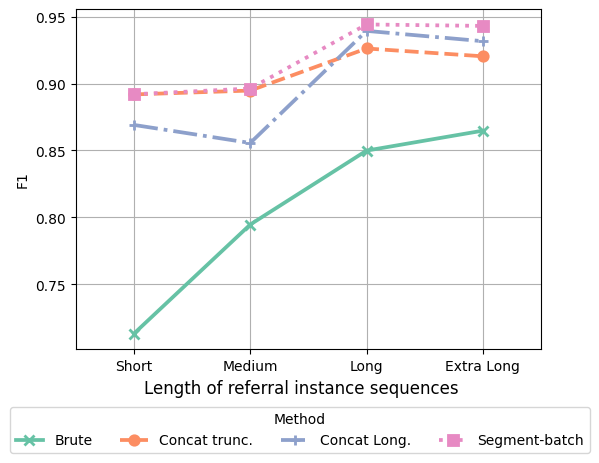

In [41]:
# make a plot
f, ax = plt.subplots(1, 1,sharey= True, sharex=True, figsize=(6,5))

g = sns.pointplot(x = 'Instance Length', y = 'F1',
                data = mixed_length_metrics_df,
                hue = "Method",
                # hue_order=["None", "MLM", "Note contrastive", "DeCLUTR"],
                # style = "domain_pretraining",
                                  
                join = True,
                # s = 5000,
                palette="Set2",
                linestyles = ["-", "--", "-.", ":"],
                # linestyles = ["", "", "", ""],
                markers = ["x","o", "+", "s"],
                ax=ax,
)
# axes[0].set_style(style='white')
# set title for 1st plot
# ax.set_title("F1 by instance length")
ax.set_xlabel(" ")
ax.set_ylabel("F1")
# set y tick label font sizes
ax.tick_params(axis='y')
ax.grid()

plt.legend(loc='upper right', 
           bbox_to_anchor=(1.12, -0.15),  
           fancybox=True, shadow=False,
           title = "Method",
           ncol=5)

f.suptitle("Length of referral instance sequences", x=0.5, y=0.14, ha='center')
# plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
f.subplots_adjust(bottom=0.2)
f.subplots_adjust(wspace=0.05)
plt.savefig(f"{save_path}/mixed_sequence_length_f1.png", 
            dpi = 300,
            bbox_inches='tight')
plt.show()


In [42]:
save_path

'/mnt/sdc/niallt/saved_models/ohft_triage/figures/'

In [147]:
# print latex
print(mixed_length_metrics_df.to_latex(index = False,
                                                        multirow= True,
                                                        multicolumn=True,
                                                        float_format="%.3f",
                                                        position = "htp",
                                                        caption = "Classification metrics for IID voting versus concatenated sequences...",
                                                        label = "tab:classification_metrics",)
                                )

\begin{table}[htp]
\centering
\caption{Classification metrics for IID voting versus concatenated sequences...}
\label{tab:classification_metrics}
\begin{tabular}{llrrrrr}
\toprule
       Method & Instance Length &  Num. Samples &  Accuracy &    F1 &  Precision &  Recall \\
\midrule
        Brute &           Short &           395 &     0.894 & 0.713 &      0.647 &   0.823 \\
Concat trunc. &           Short &           395 &     0.965 & 0.892 &      0.898 &   0.895 \\
   Longformer &           Short &           395 &     0.952 & 0.869 &      0.926 &   0.836 \\
      Segment &           Short &           395 &     0.959 & 0.892 &      0.917 &   0.875 \\
        Brute &          Medium &           801 &     0.940 & 0.795 &      0.779 &   0.835 \\
Concat trunc. &          Medium &           801 &     0.975 & 0.895 &      0.911 &   0.880 \\
   Longformer &          Medium &           801 &     0.966 & 0.856 &      0.866 &   0.856 \\
      Segment &          Medium &           801 &     0.973

/tmp/ipykernel_41635/584341538.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(mixed_length_metrics_df.to_latex(index = False,


### lets look at the inference times 


right now these data are only on the AWS instance and need exporting

In [148]:
iid_times = [
            683.3349,
             682.5075,
             683.151,
             683.2697,
             683.133,
             683.0474,
             683.9903,
             683.8267,
             683.41,
             683.1124
             ]

concat_times = [
            14.5598,
            14.55167,
            14.57302,
            14.5862,
            14.58316,
            14.5691,
            14.5683,
            14.55287,
            14.5515,
            14.56483
]

long_concat_times = [
    212.2624,
    212.7714,
    212.8498,
    212.7266,
    212.8923,
    212.8553,
    212.806,
    213.0336,
    212.8904,
    212.8420        
]

chunk_times = [
    98.4226,
    98.2196,
    99.5631,
    97.1895,
    97.5594,
    97.5320,
    97.72315,
    97.693,
    97.4997,
    97.4244
]

# add all times to a dataframe
all_times_df = pd.DataFrame({"iid":iid_times,
                            "concat":concat_times,
                            "longformer":long_concat_times,
                            "chunk":chunk_times})

# desribe
all_times_df.describe()


,iid,concat,longformer,chunk
count,10.000000,10.000000,10.000000,10.000000
mean,683.278290,14.566045,212.792980,97.882645
std,0.413736,0.012448,0.203668,0.695617
min,682.507500,14.551500,212.262400,97.189500
25%,683.117550,14.554602,212.780050,97.507775
50%,683.210350,14.566565,212.845900,97.626200
75%,683.391225,14.572040,212.881625,98.095488
max,683.990300,14.586200,213.033600,99.563100
